In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import FunctionTransformer

### 1.1. Logistic Regression
- territories removed
- columns cleaned up

In [4]:
df=pd.read_parquet('../data/subset_df.parquet')

In [28]:
# Select 3 most common disaster types
top_disasters=df['incident_type'].value_counts().head(3).index
df['top_disasters']=df['incident_type'].apply(lambda x: 1 if x in top_disasters else 0)

# Create 'year' column to filter year from 'incident_dtm'
df['year']=pd.to_datetime(df['incident_dtm'], format='%Y').dt.year

# Aggregate monthly disaster counts
df['month']=df['incident_dtm'].dt.to_period('M')
monthly_disasters=df.groupby('month')['top_disasters'].sum()

In [29]:
# Create a DataFrame with features
monthly_features=pd.DataFrame({'month': monthly_disasters.index.to_timestamp(), 'disaster_count': monthly_disasters.values})

# Create lagged features
monthly_features['lag_1']=monthly_features['disaster_count'].shift(1)
monthly_features['lag_2']=monthly_features['disaster_count'].shift(2)
monthly_features['lag_3']=monthly_features['disaster_count'].shift(3)

# Add a binary for disaster occurrence
monthly_features['disaster?']=monthly_features['disaster_count'].apply(lambda x: 1 if x > 0 else 0)

# Drop rows with NaN values created by lagging
monthly_features.dropna(inplace=True)

In [30]:
# Features and target variable
X=monthly_features[['lag_1', 'lag_2', 'lag_3']]
y=monthly_features['disaster?']

# Train-test split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

Training data shape: (551, 3), Testing data shape: (138, 3)


In [31]:
# Define transformers for sine and cosine
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

# Add 'month_int' column to represent months as integers
monthly_features['month_int']=monthly_features['month'].dt.month

# Apply sine and cosine transformations
monthly_features['month_sin']=sin_transformer(12).fit_transform(monthly_features[['month_int']])
monthly_features['month_cos']=cos_transformer(12).fit_transform(monthly_features[['month_int']])

In [32]:
# Create a one-hot encoded DataFrame for the 'state' column
state_dummies=pd.get_dummies(df['state'], prefix='state')

# Merge the one-hot encoded states into the dataset
monthly_features=pd.concat([monthly_features, state_dummies], axis=1)

In [33]:
# Train logistic regression model
model=LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred=model.predict(X_test)
y_pred_proba=model.predict_proba(X_test)[:, 1]

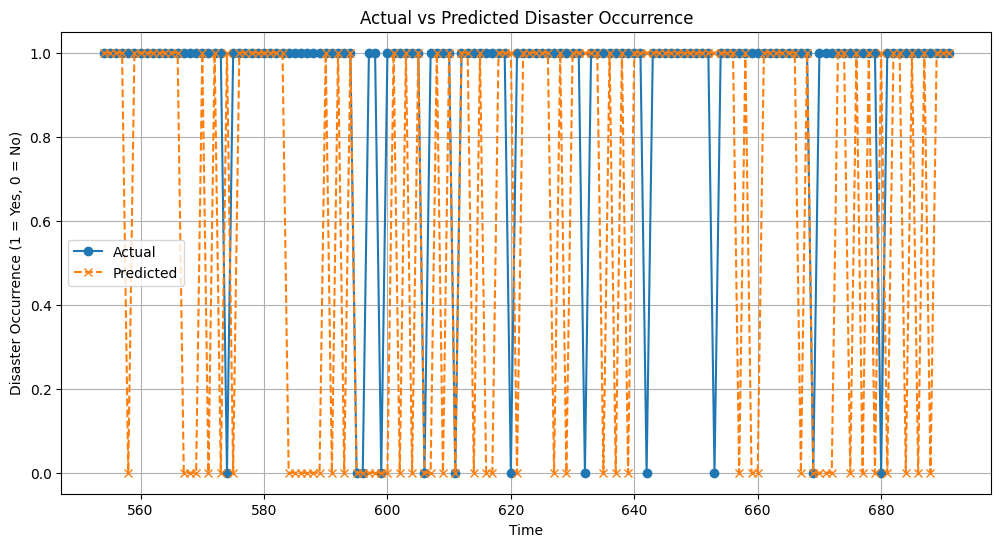

In [34]:
# Add predictions to the test set
results=X_test.copy()
results['actual']=y_test
results['predicted']=y_pred

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['actual'], label='Actual', marker='o')
plt.plot(results.index, results['predicted'], label='Predicted', marker='x', linestyle='--')
plt.title('Actual vs Predicted Disaster Occurrence')
plt.xlabel('Time')
plt.ylabel('Disaster Occurrence (1 = Yes, 0 = No)')
plt.legend()
plt.grid()
plt.show()

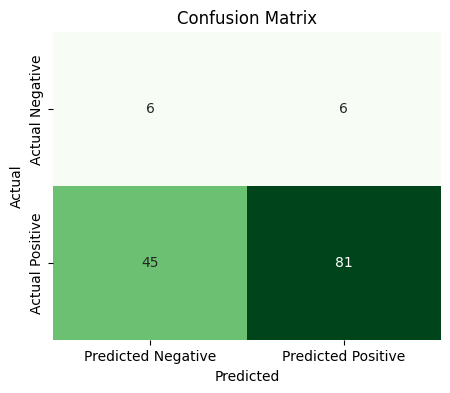

In [35]:
# Computing the confusion matrix
disaster_cm=confusion_matrix(y_test, y_pred)

# Converting the confusion matrix to a DataFrame for easier visualization
cm_df=pd.DataFrame(disaster_cm, 
                     index=['Actual Negative', 'Actual Positive'], 
                     columns=['Predicted Negative', 'Predicted Positive'])

# Plotting the confusion matrix
plt.figure(figsize=(5, 4)) 
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False, cmap='Greens')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [36]:
# Accuracy score
accuracy=accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Precision
precision=precision_score(y_test, y_pred)
print(f'Precision: {precision}')

# Recall (Sensitivity)
recall=recall_score(y_test, y_pred)
print(f'Recall: {recall}')

# F1 Score
f1=f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

Accuracy: 0.6304347826086957
Precision: 0.9310344827586207
Recall: 0.6428571428571429
F1 Score: 0.7605633802816901


### 1.2. Logistic Regression
- territories removed
- columns cleaned up
- last 7 years only (2016-2023)

In [84]:
df=pd.read_parquet('../data/subset_df.parquet')

In [85]:
# Select 3 most common disaster types
top_disasters=df['incident_type'].value_counts().head(3).index
df['top_disasters']=df['incident_type'].apply(lambda x: 1 if x in top_disasters else 0)

# Create 'year' column to filter year from 'incident_dtm'
df['year']=pd.to_datetime(df['incident_dtm'], format='%Y').dt.year

# Drop years before 2016
df=df[df['year'] >= 2016]

# Aggregate monthly disaster counts
df['month']=df['incident_dtm'].dt.to_period('M')
monthly_disasters=df.groupby('month')['top_disasters'].sum()

In [86]:
# Create a DataFrame with features
monthly_features=pd.DataFrame({'month': monthly_disasters.index.to_timestamp(), 'disaster_count': monthly_disasters.values})

# Create lagged features
monthly_features['lag_1']=monthly_features['disaster_count'].shift(1)
monthly_features['lag_2']=monthly_features['disaster_count'].shift(2)
monthly_features['lag_3']=monthly_features['disaster_count'].shift(3)

# Add a binary for disaster occurrence
monthly_features['disaster?']=monthly_features['disaster_count'].apply(lambda x: 1 if x > 0 else 0)

# Drop rows with NaN values created by lagging
monthly_features.dropna(inplace=True)

In [87]:
# Features and target variable
X=monthly_features[['lag_1', 'lag_2', 'lag_3']]
y=monthly_features['disaster?']

# Train-test split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

Training data shape: (63, 3), Testing data shape: (16, 3)


In [88]:
# Define transformers for sine and cosine
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

# Add 'month_int' column to represent months as integers
monthly_features['month_int']=monthly_features['month'].dt.month

# Apply sine and cosine transformations
monthly_features['month_sin']=sin_transformer(12).fit_transform(monthly_features[['month_int']])
monthly_features['month_cos']=cos_transformer(12).fit_transform(monthly_features[['month_int']])

In [89]:
# Create a one-hot encoded DataFrame for the 'state' column
state_dummies=pd.get_dummies(df['state'], prefix='state')

# Merge the one-hot encoded states into the dataset
monthly_features=pd.concat([monthly_features, state_dummies], axis=1)

In [90]:
# Train logistic regression model
model=LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred=model.predict(X_test)
y_pred_proba=model.predict_proba(X_test)[:, 1]

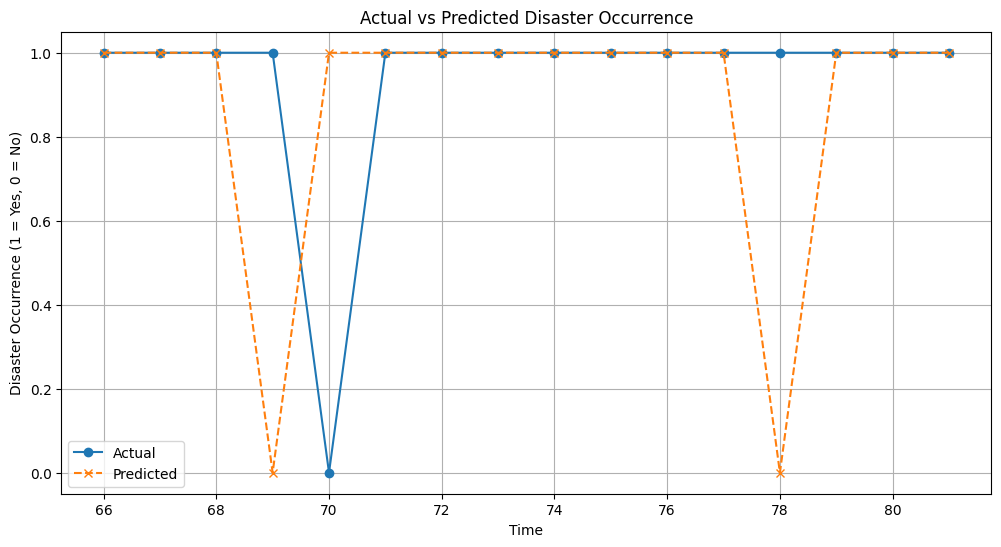

In [91]:
# Add predictions to the test set
results=X_test.copy()
results['actual']=y_test
results['predicted']=y_pred

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['actual'], label='Actual', marker='o')
plt.plot(results.index, results['predicted'], label='Predicted', marker='x', linestyle='--')
plt.title('Actual vs Predicted Disaster Occurrence')
plt.xlabel('Time')
plt.ylabel('Disaster Occurrence (1 = Yes, 0 = No)')
plt.legend()
plt.grid()
plt.show()

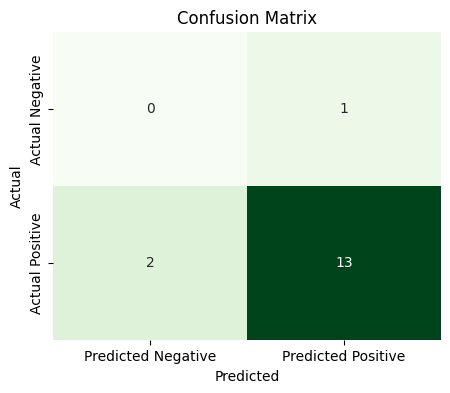

In [92]:
# Computing the confusion matrix
disaster_cm=confusion_matrix(y_test, y_pred)

# Converting the confusion matrix to a DataFrame for easier visualization
cm_df=pd.DataFrame(disaster_cm, 
                     index=['Actual Negative', 'Actual Positive'], 
                     columns=['Predicted Negative', 'Predicted Positive'])

# Plotting the confusion matrix
plt.figure(figsize=(5, 4)) 
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False, cmap='Greens')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [93]:
# Accuracy score
accuracy=accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Precision
precision=precision_score(y_test, y_pred)
print(f'Precision: {precision}')

# Recall (Sensitivity)
recall=recall_score(y_test, y_pred)
print(f'Recall: {recall}')

# F1 Score
f1=f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

Accuracy: 0.8125
Precision: 0.9285714285714286
Recall: 0.8666666666666667
F1 Score: 0.896551724137931


Accuracy improved to 81.25% (2016-2023)